# Assignment 4

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

This assignment requires that you to find **at least** two datasets on the web which are related, and that you visualize these datasets to answer a question with the broad topic of **religious events or traditions** (see below) for the region of **Ann Arbor, Michigan, United States**, or **United States** more broadly.

You can merge these datasets with data from different regions if you like! For instance, you might want to compare **Ann Arbor, Michigan, United States** to Ann Arbor, USA. In that case at least one source file must be about **Ann Arbor, Michigan, United States**.

You are welcome to choose datasets at your discretion, but keep in mind **they will be shared with your peers**, so choose appropriate datasets. Sensitive, confidential, illicit, and proprietary materials are not good choices for datasets for this assignment. You are welcome to upload datasets of your own as well, and link to them using a third party repository such as github, bitbucket, pastebin, etc. Please be aware of the Coursera terms of service with respect to intellectual property.

Also, you are welcome to preserve data in its original language, but for the purposes of grading you should provide english translations. You are welcome to provide multiple visuals in different languages if you would like!

As this assignment is for the whole course, you must incorporate principles discussed in the first week, such as having as high data-ink ratio (Tufte) and aligning with Cairo’s principles of truth, beauty, function, and insight.

Here are the assignment instructions:

 * State the region and the domain category that your data sets are about (e.g., **Ann Arbor, Michigan, United States** and **religious events or traditions**).
 * You must state a question about the domain category and region that you identified as being interesting.
 * You must provide at least two links to available datasets. These could be links to files such as CSV or Excel files, or links to websites which might have data in tabular form, such as Wikipedia pages.
 * You must upload an image which addresses the research question you stated. In addition to addressing the question, this visual should follow Cairo's principles of truthfulness, functionality, beauty, and insightfulness.
 * You must contribute a short (1-2 paragraph) written justification of how your visualization addresses your stated research question.

What do we mean by **religious events or traditions**?  For this category you might consider calendar events, demographic data about religion in the region and neighboring regions, participation in religious events, or how religious events relate to political events, social movements, or historical events.

## Tips
* Wikipedia is an excellent source of data, and I strongly encourage you to explore it for new data sources.
* Many governments run open data initiatives at the city, region, and country levels, and these are wonderful resources for localized data sources.
* Several international agencies, such as the [United Nations](http://data.un.org/), the [World Bank](http://data.worldbank.org/), the [Global Open Data Index](http://index.okfn.org/place/) are other great places to look for data.
* This assignment requires you to convert and clean datafiles. Check out the discussion forums for tips on how to do this from various sources, and share your successes with your fellow students!

## Example
Looking for an example? Here's what our course assistant put together for the **Ann Arbor, MI, USA** area using **sports and athletics** as the topic. [Example Solution File](./readonly/Assignment4_example.pdf)

<IPython.core.display.Javascript object>


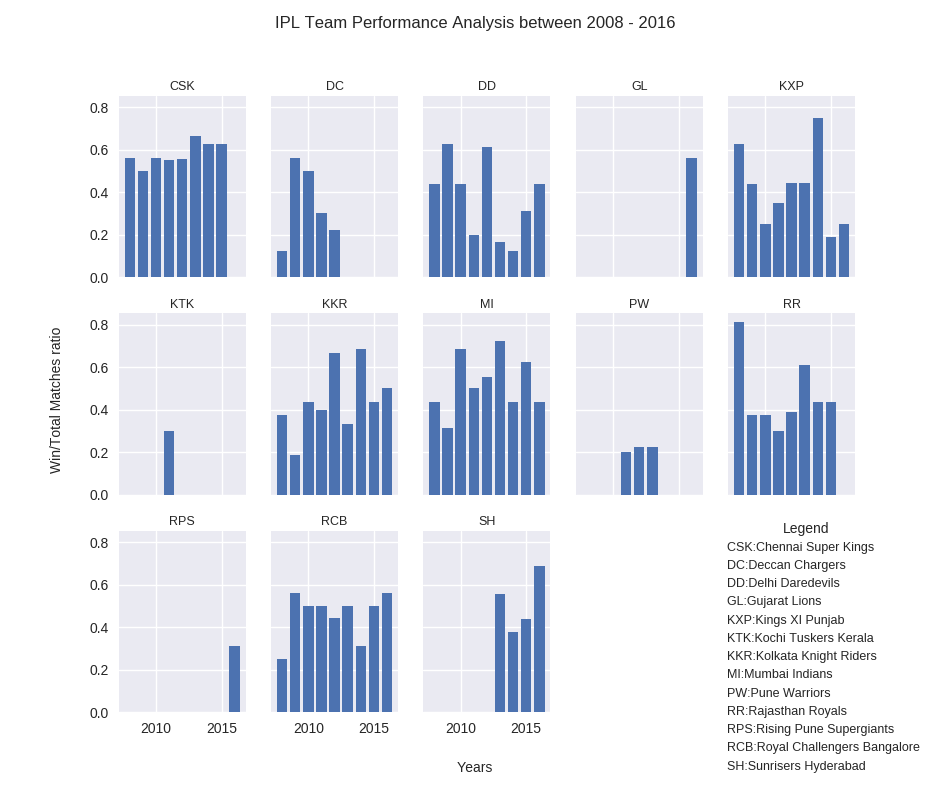

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

%matplotlib notebook

# Reading csv files
t20_series = pd.read_csv("t20_series.csv")
t20_matches = pd.read_csv("t20_matches.csv")

start_year = 2008
def inc_season(x):
    global start_year
    x = str(start_year)
    start_year += 1
    return x

# Cleaning t20_series dataframe
def clean_t20_series():
    df = t20_series[(t20_series["series"] == "Indian Premier League (in India)") | (t20_series["series"] == "Indian Premier League (in South Africa)") | (t20_series["series"] == "Pepsi Indian Premier League (in India)") | (t20_series["series"] == "Pepsi Indian Premier League (in India/United Arab Emirates)")]
    df = df.drop(labels=["margin"], axis=1)
    df["season"] = df["season"].apply(inc_season)
    return df

def get_series_id():
    df = clean_t20_series()
    series_id = df["series_id"].tolist()
    return series_id

remove_row = []
row_counter = 0

def remove_columns(x):
    global row_counter
    global remove_row
    if x.find("Match abandoned without a ball bowled") != -1 or x.find("No result") != -1:
        remove_row.append(row_counter)
    row_counter += 1
    return 

def remove_year(x):
    global row_counter
    global remove_row
    if x == "2017":
        remove_row.append(row_counter)
    row_counter += 1
    return 

# Cleaning t20_matches dataframe
def clean_t20_matches():
    global remove_row
    global row_counter
    series_id = get_series_id()
    df = t20_matches
    df = df[df["series_id"].map(lambda x:x in series_id)]
    df["winner"].apply(remove_columns)
    df = df.drop(df.index[remove_row])
    
    keep_col = [
        "match_id",
        "series_id",
        "date",
        "winner"
    ]
    df = df[keep_col]
    df["year"] = df["date"].apply(lambda x:x[-4:])
    df = df.drop(labels=["date"], axis=1)
    
    remove_row = []
    row_counter = 0
    df["year"].apply(remove_year)
    df = df.drop(df.index[remove_row])
    return df

df_match = clean_t20_matches()
df_series = clean_t20_series()

# Get all teams participated in IPL
def get_teams():
    results = df_match["winner"]
    teams = results.tolist()
    teams = set(teams)
    return teams

new_series = df_match[["year", "winner"]].groupby(by=["year", "winner"]).size()
new_df = pd.DataFrame()
new_df["wins"] = new_series
new_df = new_df.reset_index()
teams = new_df.groupby(by=["year"])["winner"].size()
teams = teams.tolist()

start_year = 2008
def my_func(x):
    total_matches = teams[int(x[0]) - start_year] * 2
    return x[2] / total_matches

# Calculate win ratio for all teams
new_df["win_ratio"] = new_df.apply(my_func, axis=1)

plot_df = pd.pivot_table(data=new_df, index="winner", columns=["year"], fill_value=0)
plot_df = plot_df.drop(labels=["wins"], axis=1)
plot_df.columns = np.arange(2008, 2017)

# Plot win ratios
x_val = np.arange(2008, 2017)    
ax_list = [[] for x in range(3)]
fig, ax_list = plt.subplots(3, 5, sharex=True, sharey=True, figsize=(9.5, 8))

def get_name(team):
    team = team.split(" ")
    name = [x[0] for x in team]
    return "".join(name)

i, j = 0, 0
teams = []
for team, win_ratio in plot_df.iterrows():
    ax_list[i][j].bar(x_val, win_ratio)
    team_name = get_name(team)
    ax_list[i][j].set_xlabel(team_name, fontsize=9)
    ax_list[i][j].xaxis.set_label_position('top') 
    if j == 4:
        j, i = 0, i + 1
    else:
        j += 1
    teams.append((team, team_name))

# Create custom legend
fig.legend([mpatches.Patch(color='none') for x in teams], [x[1] + ":" + x[0] for x in teams], fontsize=9, loc=4, bbox_to_anchor=(0.98, 0.02), title="Legend")

# Remove extra subplots
fig.delaxes(ax_list[2][3])
fig.delaxes(ax_list[2][4])

fig.suptitle("IPL Team Performance Analysis between 2008 - 2016", fontsize=12)
_ = fig.text(0.5, 0.04, 'Years', ha='center', va='center')
_ = fig.text(0.06, 0.5, 'Win/Total Matches ratio', ha='center', va='center', rotation='vertical')